In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.reconstruction import MemAutoEncoder
from src.trainer.ids import MemAEIDSTrainer
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results
import itertools as it

In [2]:
# Setup base folder structure
dataset_path = "../../data/IDS2017/ids2017.csv"
export_path = "memae_experiments"
checkpoint_path = export_path + "/checkpoints"
if not os.path.exists(export_path):
    os.mkdir(export_path)
    os.mkdir(checkpoint_path)

# General arguments
batch_size = 1024
device = "cuda"
lr = 1e-4
n_epochs = 200

# Model specific arguments
mem_dim = 50
latent_dim = 1
shrink_thres = 0.0025
n_layers = 4
compression_factor = 2
act_fn = "relu"
alpha = 2e-4

print("arguments set")

arguments set


In [3]:
dataset = IDS2017Dataset(path=dataset_path)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

data loaded


## Hyperparameter search

In [10]:
batch_size = [64, 512, 1024]
mem_dims = [50, 100, 150]
latent_dim = [5, 10, dataset.in_features // 6]

for bs, md, ld in it.product(batch_size, mem_dims, latent_dim):
    n_layers = 4 if ld <= 10 else 3
    model = MemAutoEncoder(
        in_features=dataset.in_features,
        n_instances=dataset.n_instances,
        device=device,
        mem_dim=md,
        latent_dim=ld,
        shrink_thres=shrink_thres,
        n_layers=n_layers,
        compression_factor=2,
        alpha=2e-4,
        act_fn="relu",
    )
    trainer = MemAEIDSTrainer(
        train_ldr=train_ldr,
        test_ldr=test_ldr,
        device=device,
        model=model,
        batch_size=batch_size,
        lr=lr,
        n_epochs=n_epochs,
        ckpt_root=os.path.join(checkpoint_path, "memae"),
        run_test_validation=True

    )
print("MemAE model and trainer ready")
print(model)

MemAE model and trainer ready
MemAutoEncoder(
  (act_fn): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=65, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=65, bias=True)
  )
  (mem_rep): MemoryUnit()
)


## MemAE Training

In [6]:
model = MemAutoEncoder(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    mem_dim=mem_dim,
    latent_dim=latent_dim,
    shrink_thres=shrink_thres,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn="relu",
    alpha=alpha
)
trainer = MemAEIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    device=device,
    model=model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_root=os.path.join(checkpoint_path, "memae"),
    run_test_validation=True
)
print("MemAE model and trainer ready")
print(model)

MemAE model and trainer ready
MemAutoEncoder(
  (act_fn): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=65, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=65, bias=True)
  )
  (mem_rep): MemoryUnit()
)


  1%|          | 9/1110 [00:00<00:58, 18.90it/s, epoch=1, loss=0.141]

Started training


100%|██████████| 1110/1110 [00:14<00:00, 76.45it/s, epoch=200, loss=0.011]


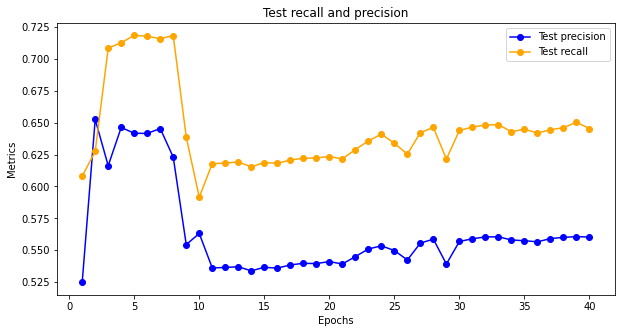

In [25]:
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
trainer.train(train_ldr)
trainer.plot_metrics(os.path.join(export_path, "memae.png"))

In [27]:
test_precision = trainer.metric_values['test_recall']
np.argmax(test_precision), np.max(test_precision)

(1, 0.6525377899279073)

In [7]:
best_epoch = 7 * 5 + 1
best = export_path + "/checkpoints/memae_epoch={}.pt".format(best_epoch)
trainer, model = MemAEIDSTrainer.load_from_file(best, trainer, model)
trainer.n_epochs = best_epoch
y_test_true, test_scores, test_labels = trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=best_epoch, **model.get_params()),
    model_name="MemAE",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6230154594676991,
 'Recall': 0.718274953689009,
 'F1-Score': 0.6672625046853525,
 'AUPR': 0.720567635795567,
 'AUROC': 0.8472783048251309,
 'Thresh_star': 0.03125389665365219,
 'Quantile_star': 62.081617244691174}

In [8]:
misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
misclf_df = misclf_df.sort_values("Misclassified ratio", ascending=False)
misclf_df.to_csv(export_path + "/memae_misclassifications.csv")
misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
Web Attack,2180,2082,0.955046
Bot,1966,1852,0.942014
PortScan,158930,82059,0.516322
SSH-Patator,5897,2949,0.500085
FTP-Patator,7938,3824,0.481733
BENIGN,1136374,242366,0.213280
DDoS,128027,26747,0.208917
DoS,252658,37586,0.148762
Infiltration,36,3,0.083333
Heartbleed,11,0,0.000000


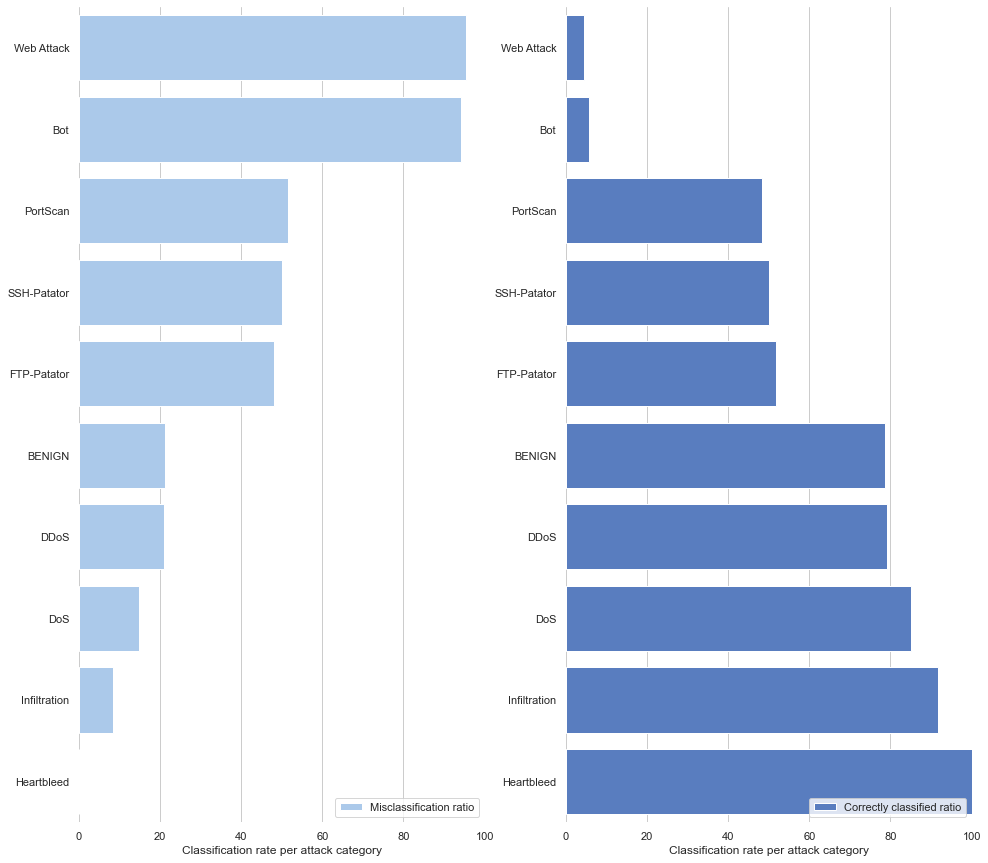

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axs = plt.subplots(figsize=(16, 15), ncols=2)

# Plot misclassification rates
sns.set_color_codes("pastel")
sns.barplot(
    x=misclf_df["Misclassified ratio"] * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Misclassification ratio",
    color="b",
    ax=axs[0]
)

# Plot correct classification rate
sns.set_color_codes("muted")
sns.barplot(
    x=(1-misclf_df["Misclassified ratio"]) * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Correctly classified ratio",
    color="b",
    ax=axs[1]
)

# Add a legend and informative axis label
for ax in axs:
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
sns.despine(left=True, bottom=True)

## Gradient analysis

In [10]:
d = trainer.inspect_gradient_wrt_input(partial_anomaly_labels)
y_grad, label_grad = d["y_grad_wrt_X"], d["label_grad_wrt_X"]
labels = d["labels"]

In [11]:
# assumes dataframe ordered from biggest to smallest value
def plt_k_top_vars(dataframe, k, scaler = 1e4):
    sns.set_theme(style="whitegrid")

    # Initialize the matplotlib figure
    figure, axes = plt.subplots(figsize=(16, 15), ncols=2)

    # Plot k biggest
    biggest_df = dataframe[0:k]
    sns.set_color_codes("pastel")
    sns.barplot(
        x=biggest_df["Sum of gradients"] * scaler,
        y=biggest_df["Variable"],
        data=biggest_df,
        label="Sum of gradients",
        color="b",
        ax=axes[0]
    )

    # Plot k smallest
    smallest_df = dataframe[-k:]
    sns.set_color_codes("muted")
    sns.barplot(
        x=smallest_df["Sum of gradients"] * scaler,
        y=smallest_df["Variable"],
        data=smallest_df,
        label="Sum of gradients",
        color="b",
        ax=axes[1]
    )

    # Add a legend and informative axis label
    for ax_i in axes:
        ax_i.legend(ncol=2, loc="lower right", frameon=True)

    xlim_max = biggest_df[0:1]["Sum of gradients"].item() * scaler
    axes[0].set(xlim=(0, xlim_max), xlabel="Top %d variables with highest gradients" % k)
    axes[1].set(xlim=(0, xlim_max), ylabel="", xlabel="Top %d variables with lowest gradients" % k)
    sns.despine(left=True, bottom=True)

In [12]:
arr = [[], []]
vals = []
for col in label_grad.keys():
    grad_df = pd.DataFrame(np.concatenate(
        (np.array(columns).reshape(65, 1), np.abs(label_grad[col].sum(axis=0)).reshape(65, 1)),
        axis=1),
        columns=["Variable", "Sum of gradients"]
    )
    grad_df["Sum of gradients"] = grad_df["Sum of gradients"].astype(np.float32)
    grad_df = grad_df.sort_values(by=["Sum of gradients"], ascending=False)[0:4]
    arr[0].extend([col] * 4)
    arr[1].extend(grad_df["Variable"].to_list())
    vals.extend(grad_df["Sum of gradients"].to_list())

index = pd.MultiIndex.from_tuples(list(zip(*arr)))
s = pd.Series(vals, index=index)
s

BENIGN        PSH Flag Count           0.404455
              Min Packet Length        0.163282
              Bwd IAT Min              0.152654
              Idle Mean                0.150985
Bot           PSH Flag Count           0.012308
              ACK Flag Count           0.008185
              Bwd Packet Length Min    0.007271
              Flow IAT Mean            0.006495
DDoS          PSH Flag Count           5.092736
              ACK Flag Count           4.549253
              Active Min               2.617788
              Flow IAT Mean            2.610903
DoS           Bwd IAT Total            2.113025
              Bwd IAT Min              1.842927
              FIN Flag Count           1.790389
              Bwd IAT Max              1.761701
FTP-Patator   PSH Flag Count           0.197990
              ACK Flag Count           0.152768
              Flow IAT Mean            0.112005
              Active Min               0.111244
Heartbleed    Flow IAT Mean            0

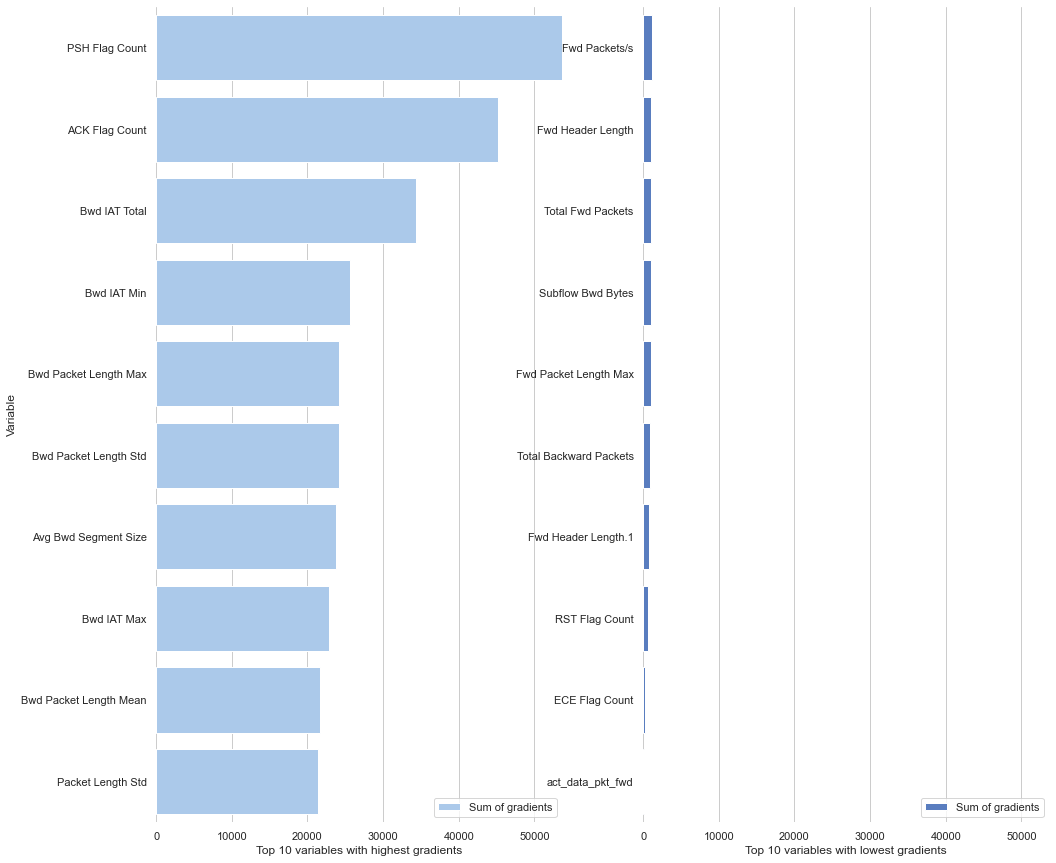

In [13]:
# Overall analysis
gradient_sum = np.asarray([label_grad[k].sum(axis=0) for k in label_grad.keys()]).sum(axis=0)
overall_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(gradient_sum).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
overall_df["Sum of gradients"] = overall_df["Sum of gradients"].astype(np.float32)
overall_df = overall_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(overall_df, k=10)

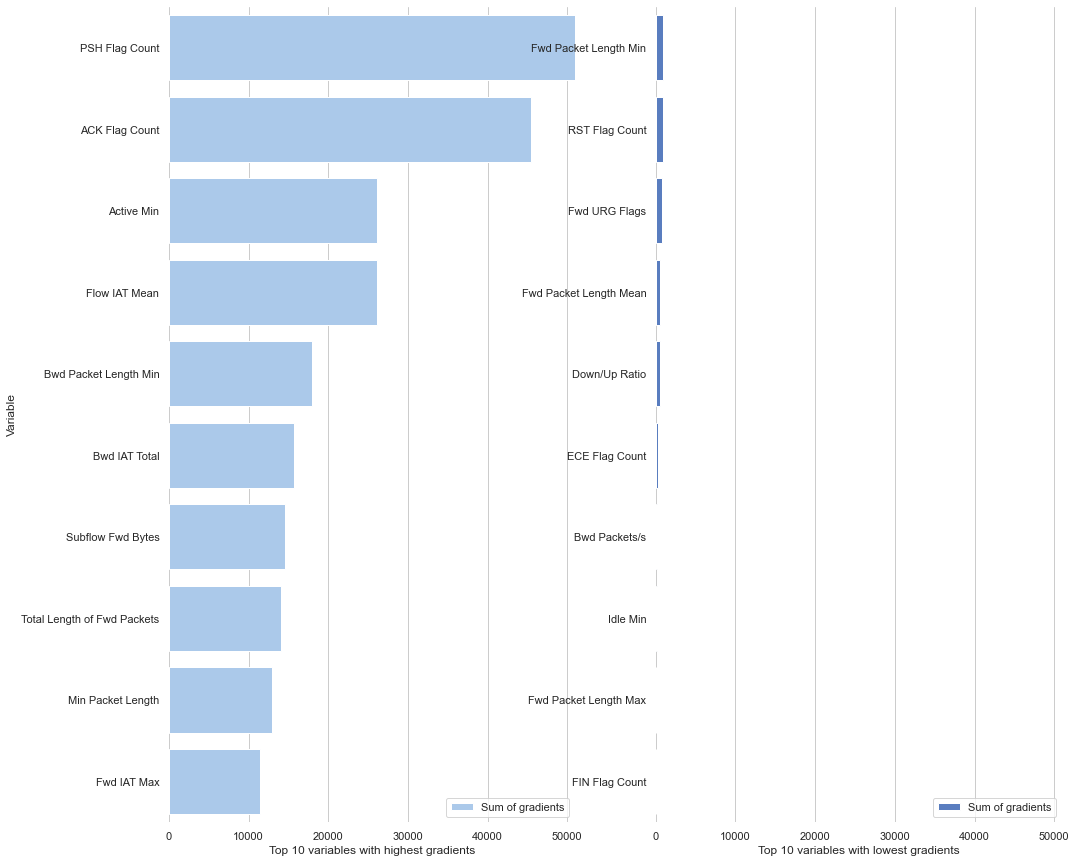

In [14]:
# DDoS analysis
ddos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["DDoS"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
ddos_df["Sum of gradients"] = ddos_df["Sum of gradients"].astype(np.float32)
ddos_df = ddos_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(ddos_df, k=10)

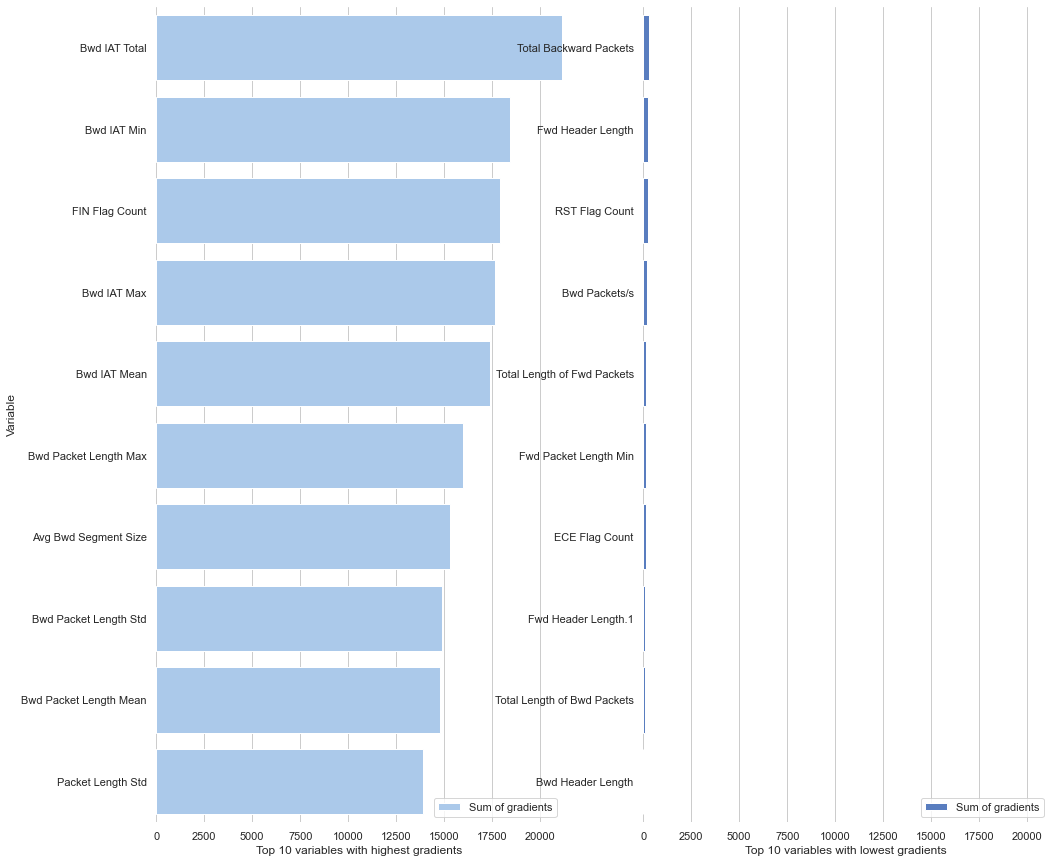

In [15]:
# DoS analysis
dos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), np.abs(label_grad["DoS"].sum(axis=0)).reshape(65, 1)),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
dos_df["Sum of gradients"] = dos_df["Sum of gradients"].astype(np.float32)
dos_df = dos_df.sort_values(by=["Sum of gradients"], ascending=False)
plt_k_top_vars(dos_df, k=10)